# Image preprocessing to run VirtualMultiplexer 

## Download the following content from [Figshare]( https://figshare.com/projects/VirtualMultiplexer/230498)
- images
- pre-extracted tissue masks
- pre-extracted cell-level bounding boxes with labels (positive and negative)

In [1]:
from typing import List
import os
import numpy as np
from PIL import Image
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as patches

import sys
sys.path.append('/Users/vuhoangthuyduong/Documents/ICM/sample code/VirtualMultiplexer')

from preprocess.tissue_mask import GaussianTissueMask

### Util functions

In [2]:
def plot_image(
    image: np.ndarray
):
    plt.imshow(image)
    plt.show()
    plt.close()

def read_image(
    image_fpath: str
) -> np.ndarray:
    return np.array(Image.open(image_fpath))

def get_tissue_mask(
    image: np.ndarray,
    kernel_size: int = 20,
    sigma: int = 20,
    downsample: int = 8,
    background_gray_threshold: int = 220,
    **kwargs
) -> np.ndarray:
    tissue_detector = GaussianTissueMask(
        kernel_size=kernel_size,
        sigma=sigma,
        downsampling_factor=downsample,
        background_gray_value=background_gray_threshold
    )
    return tissue_detector.process(image)

def get_image_patches(
    image: np.ndarray, 
    tissue_mask: np.ndarray,
    patch_size: int = 512,
    patch_tissue_threshold: float = 0.7,
    is_visualize: bool = True
) -> List[np.ndarray]:
    patch_threshold = int(patch_size * patch_size * patch_tissue_threshold)
    
    # image and tissue mask pre-processing
    h, w, c = image.shape
    pad_b = patch_size - h % patch_size
    pad_r = patch_size - w % patch_size
    image_ = np.pad(image, ((0, pad_b), (0, pad_r), (0, 0)), mode='constant', constant_values=255)
    tissue_mask_ = np.pad(tissue_mask, ((0, pad_b), (0, pad_r)), mode='constant', constant_values=0)
    
    if is_visualize:
        fig, ax = plt.subplots()
        ax.imshow(Image.fromarray(image_))
    
    # extract patches
    patches = []
    for y in range(0, image_.shape[0], patch_size):
        for x in range(0, image_.shape[1], patch_size):
            tissue_patch_ = tissue_mask_[y:y + patch_size, x:x + patch_size]
            if np.sum(tissue_patch_) > patch_threshold:
                patches.append(
                    image_[y:y + patch_size, x:x + patch_size, :]
                )
    
                if is_visualize:
                    rect = matplotlib.patches.Rectangle((x, y), patch_size, patch_size,
                                             linewidth=1, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)
    
    if is_visualize:
        plt.show()
        
    return patches

def plot_nuclei_labels(
    image: np.ndarray, 
    bbox_info: np.ndarray = None,
    save_fpath: str = None
):
    color_palette = {
        0 : 'r',    # NEG nuclei
        1 : 'b'     # POS nuclei
    }
    fig, ax = plt.subplots()
    ax.imshow(Image.fromarray(image))

    for k in range(bbox_info.shape[0]):
        y0, x0, y1, x1, label = bbox_info[k]
        rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=0.5, edgecolor=color_palette[label], facecolor='none')
        ax.add_patch(rect)
    
    if save_fpath is not None:
        plt.savefig(save_fpath, dpi=600)

    plot_image(image)

## Constants

In [3]:
# source and destination markers
src_marker = 'HE'
dst_marker = 'NKX3'

# sample image names
image_name_src = 'D9_TMA_15_02_IIIB_HE_01.9250_4.5'
image_name_dst = image_name_src.replace(src_marker, dst_marker)

# tissue mask params
tissue_mask_params = {
    'kernel_size': 20,
    'sigma': 20,
    'downsample': 8,
    'background_gray_threshold': 220
}

# patch extraction params
patch_extraction_params = {
    'patch_size': 512,
    'patch_tissue_threshold': 0.7,
    'is_visualize': True
}

## Preprocess

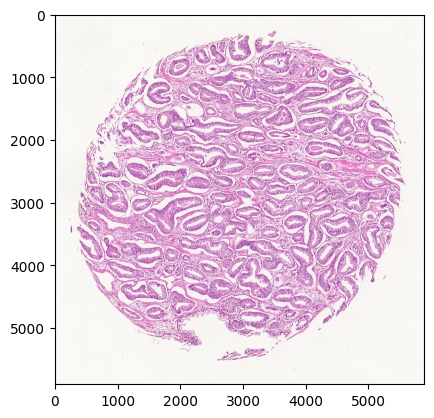

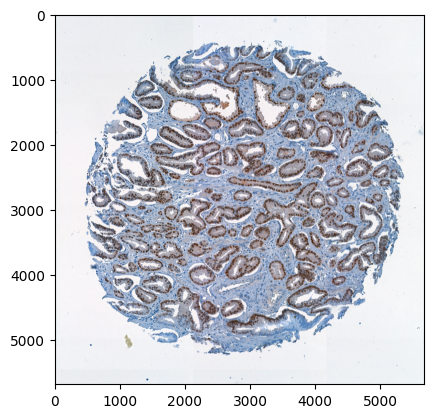

In [4]:
# src tma image (download the images from zenodo)
image_src = read_image(f'./data/{image_name_src}.png')
plot_image(image_src)

# dst tma image (download the images from zenodo)
image_dst = read_image(image_fpath=f'./data/{image_name_dst}.png')
plot_image(image_dst)

/Users/vuhoangthuyduong/Documents/ICM/sample code/VirtualMultiplexer/preprocess/tissue_mask.py:50: FutureWarning: Parameter `output` is deprecated since version 0.23 and will be removed in 0.25 (or later). To avoid this warning, please use the parameter `out` instead. For more details, see the documentation of `gaussian`.
  thumbnail = gaussian(


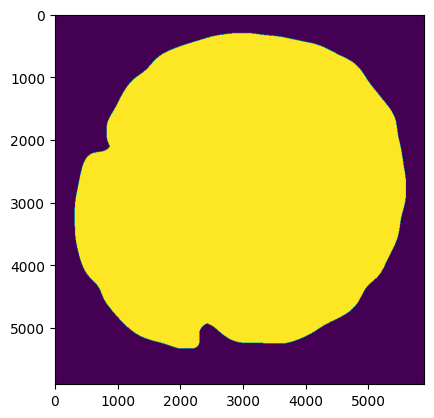

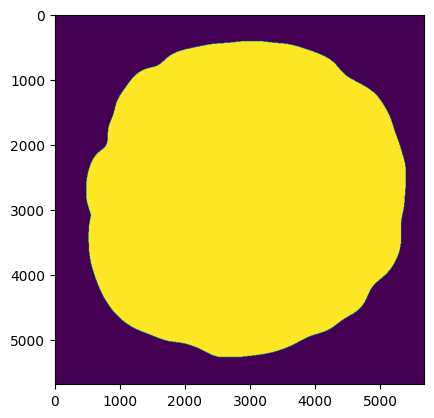

In [5]:
# src tissue mask (download the pre-extracted tissue masks from zenodo)
tissue_mask_src = get_tissue_mask(image=image_src, **tissue_mask_params)
plot_image(tissue_mask_src)

# dst tissue mask (download the pre-extracted tissue masks from zenodo)
tissue_mask_dst = get_tissue_mask(image=image_dst, **tissue_mask_params)
plot_image(tissue_mask_dst)

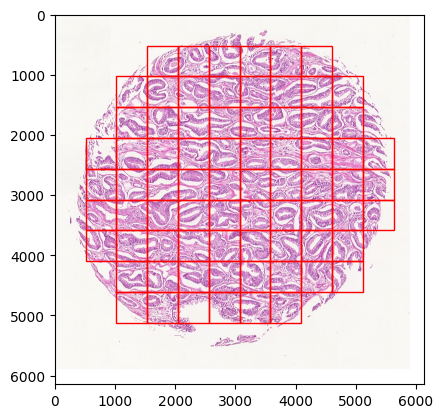

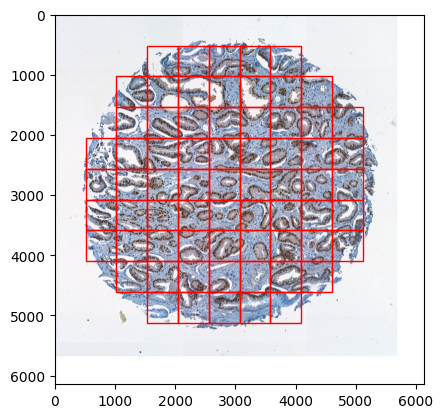

In [6]:
# extract src patches
patches_src = get_image_patches(
    image=image_src,
    tissue_mask=tissue_mask_src,
    **patch_extraction_params
)

# extract dst patches
patches_dst = get_image_patches(
    image=image_dst,
    tissue_mask=tissue_mask_dst,
    **patch_extraction_params
)

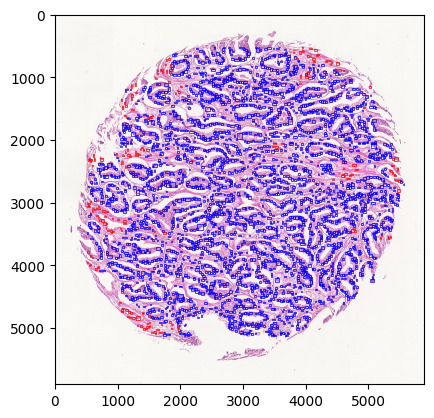

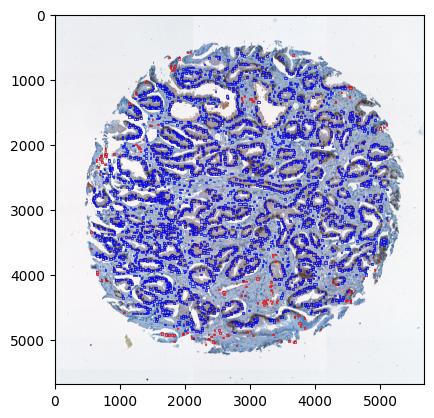

In [7]:
# read and plot bbox info for src (download the pre-extracted bbox-info from zenodo)
data = np.load(os.path.join('./data', 'bbox_info', f'{src_marker}_{dst_marker}', src_marker, f'{image_name_src}.npz'))
bbox_info = data['bbox']        # (y0, x0, y1, x1, label)
# overlay nuclei labels on image
plot_nuclei_labels(image=image_src, bbox_info=bbox_info)

# read and plot bbox info for dst (download the pre-extracted bbox-info from zenodo)
data = np.load(os.path.join('./data', 'bbox_info', f'{src_marker}_{dst_marker}', dst_marker, f'{image_name_dst}.npz'))
bbox_info = data['bbox']        # (y0, x0, y1, x1, label)
# overlay nuclei labels on image
plot_nuclei_labels(image=image_dst, bbox_info=bbox_info)